**Parametros del modelo**

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Definir parámetros del problema

# Intervalos de tiempo (cada 10 minutos desde las 5 am hasta las 9 pm)
intervalo_minutos = 10
hora_inicio = 5 * 60  # 5 am en minutos
hora_fin = 21 * 60    # 9 pm en minutos
N = int((hora_fin - hora_inicio) / intervalo_minutos)  # Número de intervalos: 96
T = list(range(N+1))  # Conjunto de intervalos de tiempo: 0,1,...,96

# Ubicaciones
L = ['P', 'C1', 'C2']

# Sentidos
S = [1, 2]

# Buses disponibles
B = 8
K = list(range(1, B+1))  # Conjunto de buses: 1,2,3,4,5

# Capacidad de cada bus
C = 52

# Definir función para obtener tiempo de viaje entre ubicaciones (en número de intervalos)
def T_l_lprime(l, l_prime):
    if l == 'P' and l_prime == 'C1':
        return 2  # 20 minutos
    elif l == 'P' and l_prime == 'C2':
        return 3  # 20 minutos
    elif l == 'C1' and l_prime == 'P':
        return 2  # 20 minutos
    elif l == 'C2' and l_prime == 'P':
        return 3  # 20 minutos
    elif l == 'C1' and l_prime == 'C2':
        return 4  # 30 minutos
    elif l == 'C2' and l_prime == 'C1':
        return 4  # 30 minutos
    elif l == l_prime:
        return 1  # Permanencia en la misma ubicación por un intervalo (10 minutos)
    else:
        return N + 1  # Movimiento inválido

# Parámetros de costos
c_mov = 10        # Costo fijo por movimiento
c_bus = 5         # Costo por tener el bus en operación (por intervalo)
c_ingreso = 2     # Ingreso por pasajero transportado
c_espera = 5      # Costo de permanencia en cabeceras por intervalo

# Lista de arcos y calcular costos
arcos = []
c = {}
delta = {}
for k in K:
    for l in L:
        for t in T:
            for l_prime in L:
                tiempo_viaje = T_l_lprime(l, l_prime)
                t_prime = t + tiempo_viaje
                if t_prime <= N:
                    arco = (k, l, t, l_prime, t_prime)
                    arcos.append(arco)
                    # Costo del arco
                    if l != l_prime:
                        c[arco] = c_mov
                    else:
                        if l != 'P':
                            c[arco] = c_espera  # Costo de espera en cabeceras
                        else:
                            c[arco] = 0  # Sin costo en el patio
                    # Delta para identificar el sentido del movimiento
                    if l == 'C1' and l_prime == 'C2':
                        delta[arco, 1] = 1
                        delta[arco, 2] = 0
                    elif l == 'C2' and l_prime == 'C1':
                        delta[arco, 1] = 0
                        delta[arco, 2] = 1
                    else:
                        delta[arco, 1] = 0
                        delta[arco, 2] = 0
                # else: movimiento no factible, no se agrega

# Demandas predichas 
D = {}
for s in S:
    for t in T:
        D[s, t] = 0  # Inicializar demanda


# Demanda para Sentido 1
demanda_sentido_1 = [19, 21, 22, 23, 25, 26, 27, 28, 29, 31, 31, 32, 33, 34, 34, 34, 35,
        35, 35, 35, 35, 35, 35, 35, 35, 34, 34, 34, 34, 34, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34,
        34, 34, 34, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 36, 36, 35, 35, 34, 33, 32, 31, 30, 29, 28,
        27, 26, 24, 23, 22, 21, 20, 19, 19, 18, 17]

# Demanda para Sentido 2
demanda_sentido_2 = [19, 21, 22, 23, 25, 26, 27, 28, 29, 31, 31, 32, 33, 34, 34, 34, 35,
        35, 35, 35, 35, 35, 35, 35, 35, 34, 34, 34, 34, 34, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34,
        34, 34, 34, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 36, 36, 35, 35, 34, 33, 32, 31, 30, 29, 28,
        27, 26, 24, 23, 22, 21, 20, 19, 19, 18, 17]

# Asignar los valores de D para cada sentido y tiempo
for t in range(N+1):
    if t < len(demanda_sentido_1):
        D[1, t] = demanda_sentido_1[t]
    else:
        D[1, t] = 0  # Si no hay datos, asignar 0

    if t < len(demanda_sentido_2):
        D[2, t] = demanda_sentido_2[t]
    else:
        D[2, t] = 0  # Si no hay datos, asignar 0

**Ejecución de modelo**

In [ ]:
# Crear el modelo
model = gp.Model("Despacho_de_Buses")

# Variables de decisión
x = model.addVars(arcos, vtype=GRB.BINARY, name="x")
L_var = model.addVars(K, L, T, vtype=GRB.BINARY, name="L")
y = model.addVars(S, T, vtype=GRB.CONTINUOUS, lb=0, name="y")
p = model.addVars(K, S, T, vtype=GRB.CONTINUOUS, lb=0, name="p")
z = model.addVars(K, T, vtype=GRB.BINARY, name="z")  # Bus en operación

# Función objetivo
model.setObjective(
    gp.quicksum(c_bus * z[k, t] for k in K for t in T) +  # Costos por tener el bus en operación
    gp.quicksum(c[arco] * x[arco] for arco in arcos) -  # Costos de movimiento y espera
    c_ingreso * gp.quicksum(p[k, s, t] for k in K for s in S for t in T),  # Ingresos por pasajeros transportados
    GRB.MINIMIZE
)

# Restricciones

# 1. Ubicación inicial de los buses
for k in K:
    for l in L:
        if l == 'P':
            model.addConstr(L_var[k, l, 0] == 1, name=f"ubicacion_inicial_{k}")
        else:
            model.addConstr(L_var[k, l, 0] == 0, name=f"ubicacion_inicial_{k}_{l}")

# 2. Exclusividad de ubicación
for k in K:
    for t in T:
        model.addConstr(
            gp.quicksum(L_var[k, l, t] for l in L) <= 1,
            name=f"exclusividad_{k}_{t}"
        )

# 3. Actualización de presencia de los buses
for k in K:
    for l in L:
        for t in T[:-1]:
            # Salidas desde (l, t)
            salidas = gp.quicksum(
                x[arco]
                for arco in arcos
                if arco[0] == k and arco[1] == l and arco[2] == t
            )
            # Llegadas a (l, t+1)
            llegadas = gp.quicksum(
                x[arco]
                for arco in arcos
                if arco[0] == k and arco[3] == l and arco[4] == t+1
            )
            model.addConstr(
                L_var[k, l, t+1] == L_var[k, l, t] - salidas + llegadas,
                name=f"actualizacion_{k}_{l}_{t}"
            )

# 4. Movimiento solo si el bus está presente
for arco in arcos:
    k, l, t, l_prime, t_prime = arco
    model.addConstr(
        x[arco] <= L_var[k, l, t],
        name=f"movimiento_{k}_{l}_{t}"
    )

# 5. Definición de z[k, t]
for k in K:
    for t in T:
        model.addConstr(
            z[k, t] == 1 - L_var[k, 'P', t],
            name=f"bus_en_operacion_{k}_{t}"
        )

# 6. Capacidad del bus en cada intervalo
for k in K:
    for t in T:
        model.addConstr(
            gp.quicksum(p[k, s, t] for s in S) <= C * z[k, t],
            name=f"capacidad_{k}_{t}"
        )

# 7. Satisfacción de la demanda
for s in S:
    for t in T:
        model.addConstr(
            gp.quicksum(p[k, s, t] for k in K) + y[s, t] == D[s, t],
            name=f"demanda_{s}_{t}"
        )

# 8. Consistencia entre movimiento y atención de pasajeros
for k in K:
    for s in S:
        for t in T:
            # Pasajeros transportados solo si el bus está realizando un movimiento en ese sentido
            movimientos_s = gp.quicksum(
                x[arco] * delta.get((arco, s), 0)
                for arco in arcos
                if arco[0] == k and arco[2] <= t and arco[4] > t
            )
            model.addConstr(
                p[k, s, t] <= C * movimientos_s,
                name=f"consistencia_{k}_{s}_{t}"
            )

# 9. No exceder la capacidad del bus acumulada
for k in K:
    for s in S:
        for t in T:
            # Acumulado de pasajeros hasta el tiempo t
            pasajeros_acumulados = gp.quicksum(p[k, s, tau] for tau in T if tau <= t)
            # No puede exceder la capacidad multiplicada por el número de viajes en ese sentido
            viajes_s = gp.quicksum(
                x[arco]
                for arco in arcos
                if arco[0] == k and delta.get((arco, s), 0) == 1 and arco[2] <= t
            )
            model.addConstr(
                pasajeros_acumulados <= C * viajes_s,
                name=f"capacidad_acumulada_{k}_{s}_{t}"
            )

# Establecer criterios de parada
model.setParam('MIPGap', 0.01)      
model.setParam('TimeLimit', 3600)    

# Optimizar el modelo
model.optimize()



Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-06
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 3600
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 14770 rows, 11666 columns and 194682 nonzeros
Model fingerprint: 0xa59f4a16
Variable types: 1746 continuous, 9920 integer (9920 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [2e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Presolve removed 3543 rows and 3522 columns
Presolve time: 0.45s
Presolved: 11227 rows, 8144 columns, 165671 nonzeros
Variable types: 1512 continuous, 6632 integer (6624 binary)
Found heuristic solution: objective -2498.000000
Found heuristic solution: objective -2574.000

**Resultados computacionales**

In [ ]:
# Información computacional del modelo
if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT:
    print("Modelo optimizado:")
    print(f"Estado de la optimización: {model.status}")
    print(f"Tiempo computacional: {model.Runtime} segundos")
    print(f"Gap: {model.MIPGap}")
    print(f"Número de iteraciones: {model.IterCount}")
    print(f"Número de variables: {model.NumVars}")
    print(f"Número de restricciones: {model.NumConstrs}")
    num_nodos = len(L) * len(T) * len(K)
    print(f"Número de nodos en la red de flujo: {num_nodos}")
    print(f"Número de arcos en la red de flujo: {len(arcos)}")
    print(f"Valor objetivo alcanzado: {model.ObjVal}")
else:
    print("El modelo no encontró una solución óptima.")


Modelo optimizado:
Estado de la optimización: 2
Tiempo computacional: 83.49399995803833 segundos
Gap: 0.006935095386108148
Número de iteraciones: 86439.0
Número de variables: 11666
Número de restricciones: 14770
Número de nodos en la red de flujo: 2328
Número de arcos en la red de flujo: 6816
Valor objetivo alcanzado: -8343.0


**Metricas de desempeño**

In [2]:
# Interpretar los resultados
if model.Status == GRB.OPTIMAL or model.Status == GRB.TIME_LIMIT:
    print("Solución Encontrada")
    
    # Demanda total y atendida
    demanda_total = {s: sum(D[s, t] for t in T) for s in S}
    demanda_atendida = {s: demanda_total[s] - sum(y[s, t].X for t in T) for s in S}
    nivel_servicio = {s: (demanda_atendida[s] / demanda_total[s]) * 100 if demanda_total[s] > 0 else 0 for s in S}
    
    # Nivel de servicio global
    demanda_total_global = sum(demanda_total.values())
    demanda_atendida_global = sum(demanda_atendida.values())
    nivel_servicio_global = (demanda_atendida_global / demanda_total_global) * 100 if demanda_total_global > 0 else 0
    print(f"\nNivel de Servicio Global: {nivel_servicio_global:.2f}%")
    
    # Mostrar nivel de servicio por sentido
    print("\nNivel de Servicio por Sentido:")
    for s in S:
        print(f"  Sentido {s}: {nivel_servicio[s]:.2f}%")
    
    # Métricas por bus
    print("\nMétricas por Bus:")
    distancia_sentido = {1: 20, 2: 22}  # Distancias en km para cada sentido
    metrics_bus = {}
    for k in K:
        # Total de pasajeros transportados
        pasajeros_k = sum(p[k, s, t].X for s in S for t in T)
        
        # Total de viajes realizados (cualquier movimiento)
        viajes_k = sum(x[arco].X for arco in arcos if arco[0] == k and x[arco].X > 0.5)
        
        # Total de intervalos en operación
        intervalos_operacion = sum(z[k, t].X for t in T)
        
        # Total de intervalos realizando trayectos de recogida de pasajeros
        intervalos_recogida = 0
        for arco in arcos:
            if arco[0] == k and x[arco].X > 0.5:
                l, l_prime = arco[1], arco[3]
                # Verificar si el movimiento está asociado a alguno de los sentidos
                if (l, l_prime) in [('C1', 'C2'), ('C2', 'C1')]:
                    intervalos_recogida += T_l_lprime(l, l_prime)
        
        # Utilización como porcentaje
        utilizacion_k = (intervalos_recogida * intervalo_minutos) / (intervalos_operacion * intervalo_minutos) * 100 if intervalos_operacion > 0 else 0
        
        # Kilómetros recorridos en trayectos de recogida de pasajeros
        km_k = 0
        for s in S:
            viajes_k_s = sum(x[arco].X for arco in arcos if arco[0] == k and delta.get((arco, s), 0) == 1 and x[arco].X > 0.5)
            km_k += viajes_k_s * distancia_sentido[s]
        ipk_k = pasajeros_k / km_k if km_k > 0 else 0

        
        metrics_bus[k] = {
            'Pasajeros Transportados': pasajeros_k,
            'Viajes Realizados': viajes_k,
            'Utilización (%)': utilizacion_k,
            'Kilómetros Recorridos': km_k,
            'IPK (Pasajeros/km)': ipk_k
        }
        print(f"Bus {k}: {metrics_bus[k]}")
    
    # Métricas globales
    print("\nMétricas Globales:")
    pasajeros_totales = sum(m['Pasajeros Transportados'] for m in metrics_bus.values())
    viajes_totales = sum(m['Viajes Realizados'] for m in metrics_bus.values())
    km_totales = sum(m['Kilómetros Recorridos'] for m in metrics_bus.values())
    utilizacion_promedio = sum(m['Utilización (%)'] for m in metrics_bus.values()) / len(K)
    ipk_global = pasajeros_totales / km_totales if km_totales > 0 else 0
    print(f"Pasajeros Totales Transportados: {pasajeros_totales}")
    print(f"Viajes Totales Realizados: {viajes_totales}")
    print(f"Kilómetros Totales Recorridos: {km_totales}")
    print(f"Utilización Promedio de los Buses: {utilizacion_promedio:.2f}%")
    print(f"IPK Global (Pasajeros/km): {ipk_global:.2f}")


Solución Encontrada

Nivel de Servicio Global: 98.33%

Nivel de Servicio por Sentido:
  Sentido 1: 98.69%
  Sentido 2: 97.97%

Métricas por Bus:
Bus 1: {'Pasajeros Transportados': 1067.0, 'Viajes Realizados': 23.0, 'Utilización (%)': 95.45454545454545, 'Kilómetros Recorridos': 442.0, 'IPK (Pasajeros/km)': 2.414027149321267}
Bus 2: {'Pasajeros Transportados': 832.0, 'Viajes Realizados': 18.0, 'Utilización (%)': 95.52238805970148, 'Kilómetros Recorridos': 336.0, 'IPK (Pasajeros/km)': 2.4761904761904763}
Bus 3: {'Pasajeros Transportados': 0.0, 'Viajes Realizados': 0, 'Utilización (%)': 0, 'Kilómetros Recorridos': 0, 'IPK (Pasajeros/km)': 0}
Bus 4: {'Pasajeros Transportados': 1193.0, 'Viajes Realizados': 24.0, 'Utilización (%)': 97.87234042553192, 'Kilómetros Recorridos': 482.0, 'IPK (Pasajeros/km)': 2.475103734439834}
Bus 5: {'Pasajeros Transportados': 1196.0, 'Viajes Realizados': 24.0, 'Utilización (%)': 95.83333333333334, 'Kilómetros Recorridos': 482.0, 'IPK (Pasajeros/km)': 2.481327800

**Visualización de resultados**

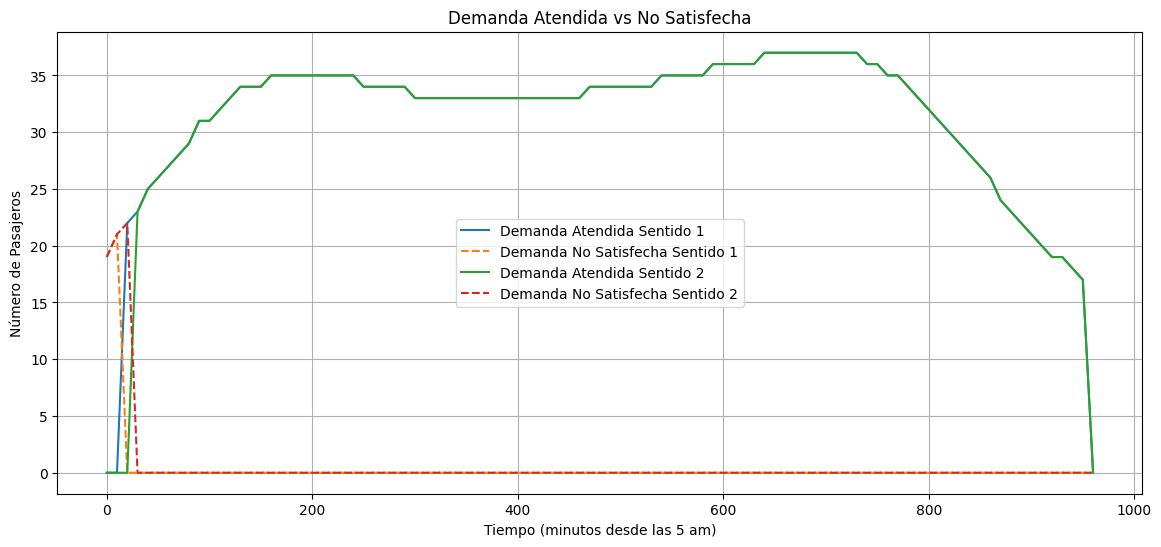

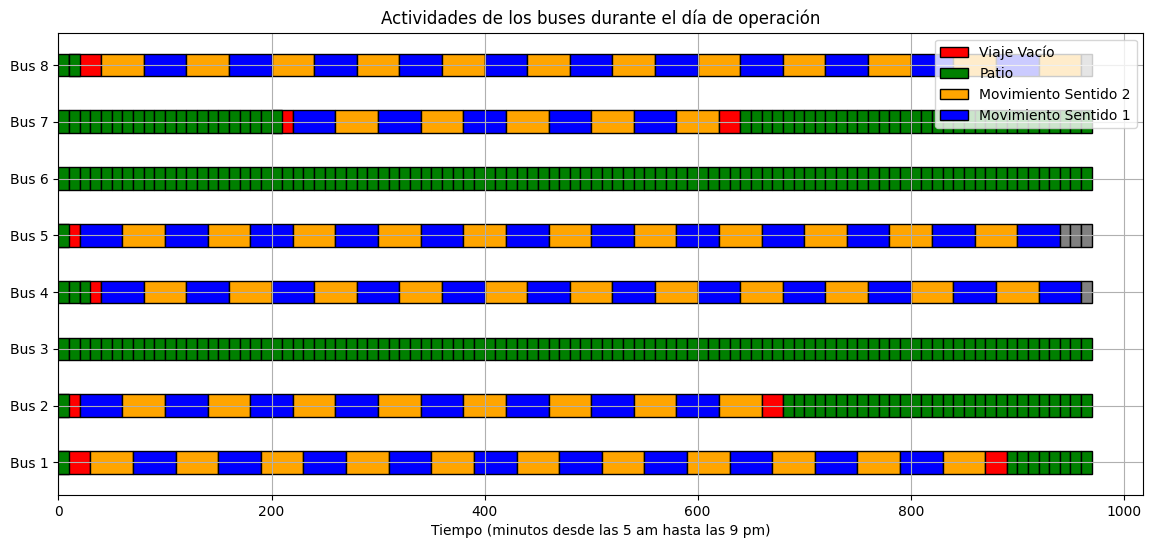

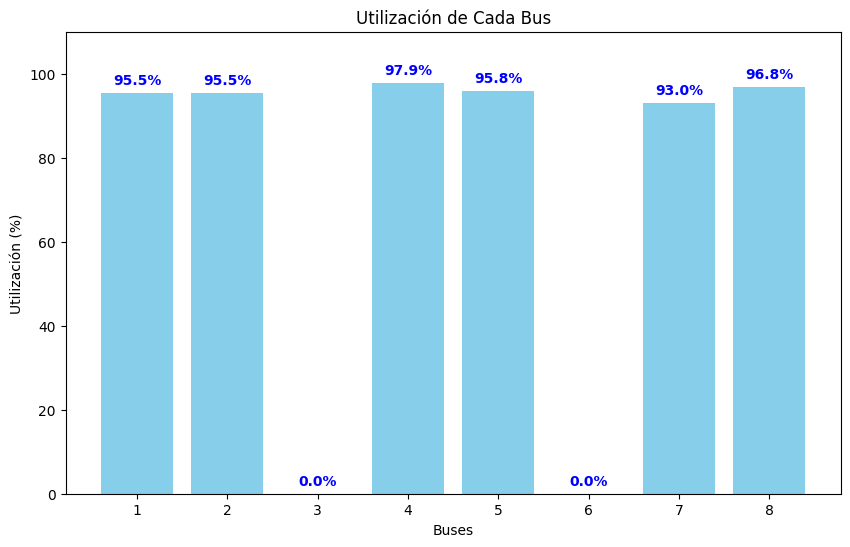

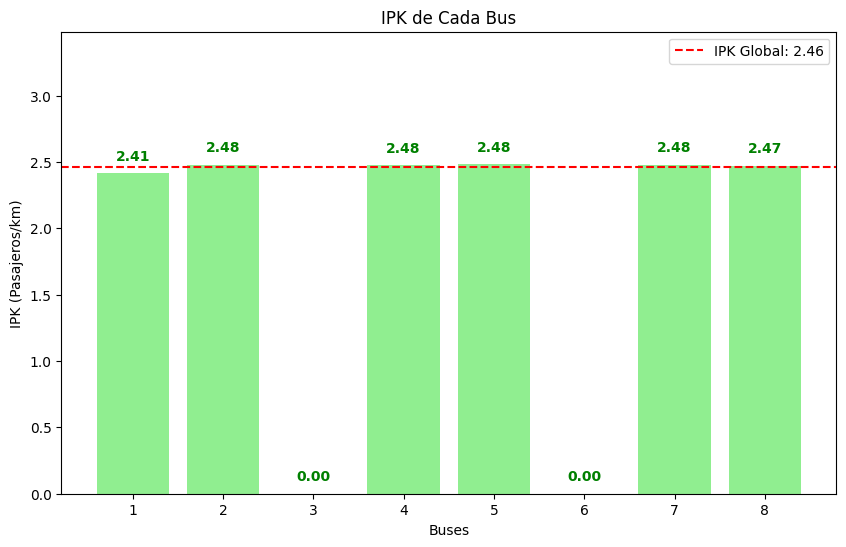

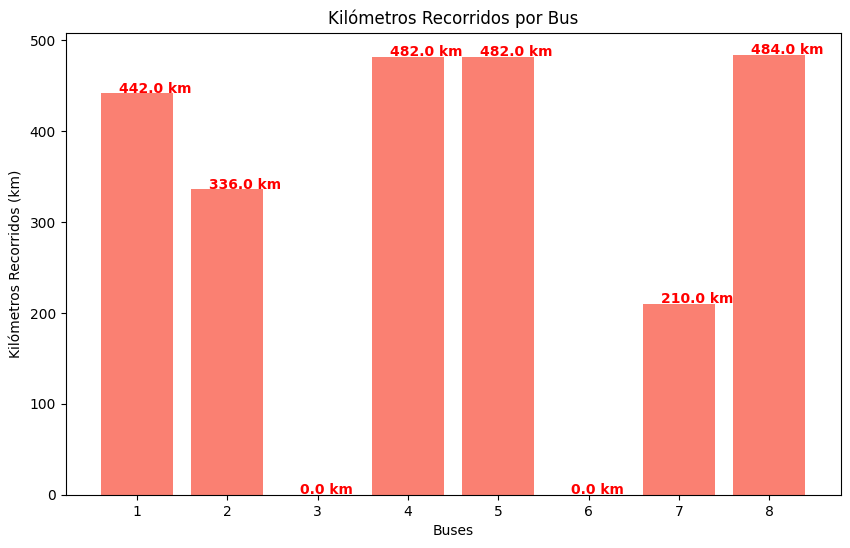

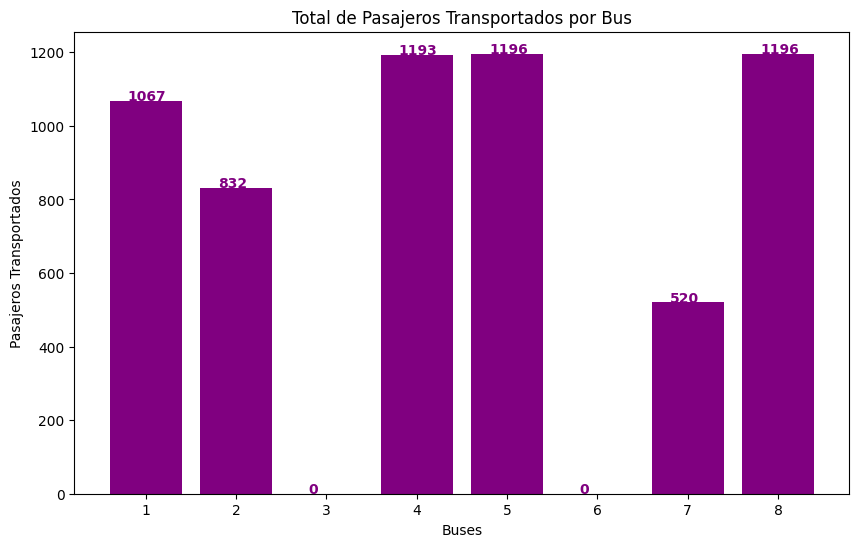

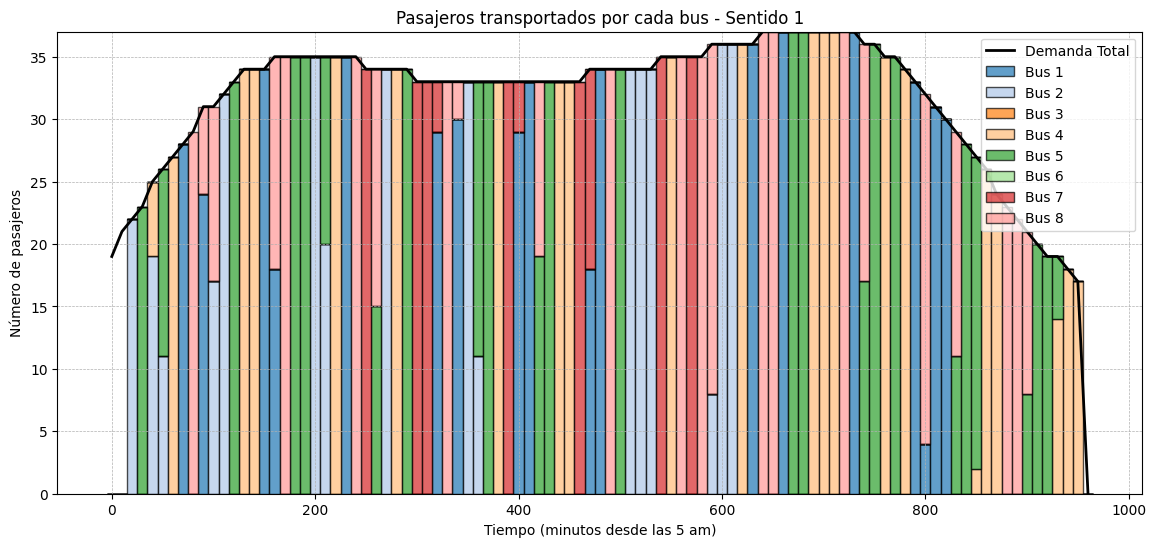

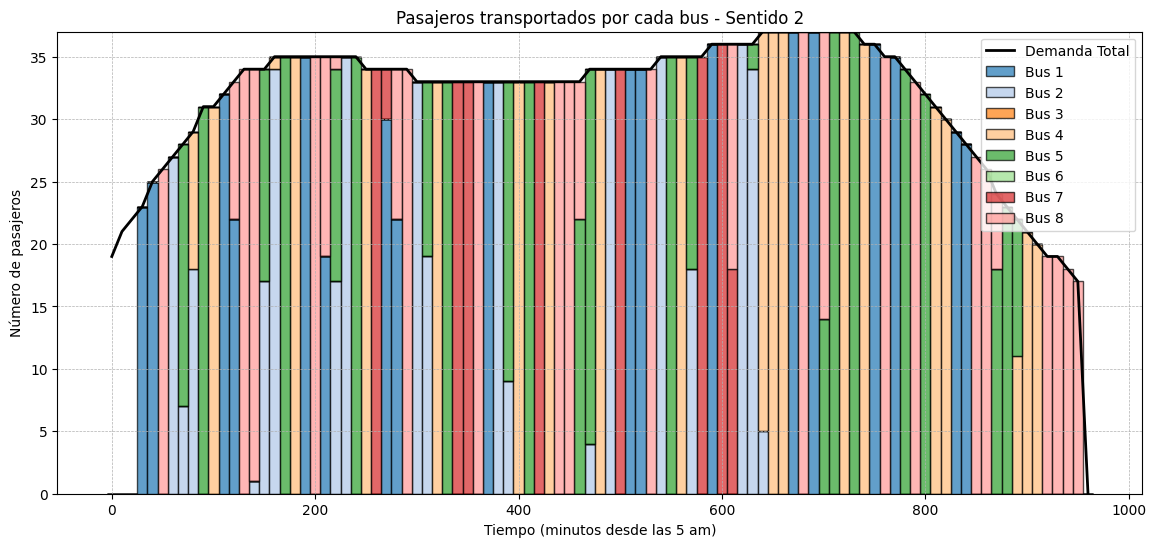

In [12]:
# 1. Gráfica de demanda atendida vs no satisfecha
tiempos = [t * intervalo_minutos for t in T]
demanda_no_satisfecha_t = {s: [y[s, t].X for t in T] for s in S}
demanda_atendida_t = {s: [D[s, t] - y[s, t].X for t in T] for s in S}

plt.figure(figsize=(14, 6))
for s in S:
    plt.plot(tiempos, demanda_atendida_t[s], label=f'Demanda Atendida Sentido {s}')
    plt.plot(tiempos, demanda_no_satisfecha_t[s], label=f'Demanda No Satisfecha Sentido {s}', linestyle='--')
plt.xlabel('Tiempo (minutos desde las 5 am)')
plt.ylabel('Número de Pasajeros')
plt.title('Demanda Atendida vs No Satisfecha')
plt.legend()
plt.grid(True)
plt.show()

# 2. Diagrama de Gantt de los buses
fig, ax = plt.subplots(figsize=(14, 6))
colores = {
    'Movimiento_Sentido_1': 'blue',
    'Movimiento_Sentido_2': 'orange',
    'Viaje_Vacio': 'red',
    'Espera': 'grey',
    'Patio': 'green'
}

for k in K:
    for t in T:
        # Verificar si el bus está moviéndose en este intervalo
        moving = False
        for arco in arcos:
            if arco[0] == k and arco[2] <= t < arco[4] and x[arco].X > 0.5:
                l, l_prime, t_start, t_end = arco[1], arco[3], arco[2], arco[4]
                sentido = None
                for s in S:
                    if delta.get((arco, s), 0) == 1:
                        sentido = s
                        break
                if sentido == 1:
                    color = colores['Movimiento_Sentido_1']
                    label = 'Movimiento Sentido 1'
                elif sentido == 2:
                    color = colores['Movimiento_Sentido_2']
                    label = 'Movimiento Sentido 2'
                else:
                    color = colores['Viaje_Vacio']
                    label = 'Viaje Vacío'
                duration = (t_end - t_start) * intervalo_minutos
                # Dibujar solo si se esta en el inicio del movimiento
                if t == t_start:
                    ax.barh(k, duration, left=t_start * intervalo_minutos, height=0.4, color=color, edgecolor='black', label=label if (k == 1 and t_start == arco[2]) else "")
                moving = True
                break  # Solo un movimiento por intervalo
        
        # Verificar si el bus está en el patio
        if L_var[k, 'P', t].X > 0.5:
            ax.barh(k, intervalo_minutos, left=t * intervalo_minutos, height=0.4, color=colores['Patio'], edgecolor='black', label='Patio' if t == 0 else "")
            continue  # No puede estar haciendo otra actividad si está en el patio            
        if moving:
            continue  # Si está moviéndose, no puede estar esperando
        
        # Si no está moviéndose y no está en el patio, está esperando en una cabecera
        ubicacion_actual = None
        for l in L:
            if L_var[k, l, t].X > 0.5:
                ubicacion_actual = l
                break
        if ubicacion_actual and ubicacion_actual != 'P':
            ax.barh(k, intervalo_minutos, left=t * intervalo_minutos, height=0.4, color=colores['Espera'], edgecolor='black', label='Espera' if t == 0 else "")


handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper right')

ax.set_yticks(K)
ax.set_yticklabels([f'Bus {k}' for k in K])
ax.set_xlabel('Tiempo (minutos desde las 5 am hasta las 9 pm)')
ax.set_title('Actividades de los buses durante el día de operación')
plt.grid(True)
plt.show()

# 3. Gráfica de Utilización de los Buses
plt.figure(figsize=(10, 6))
buses = list(metrics_bus.keys())
utilizaciones = [metrics_bus[k]['Utilización (%)'] for k in buses]
plt.bar(buses, utilizaciones, color='skyblue')
plt.xlabel('Buses')
plt.ylabel('Utilización (%)')
plt.title('Utilización de Cada Bus')
plt.ylim(0, 110)  
for i, v in enumerate(utilizaciones):
    plt.text(buses[i], v + 2, f"{v:.1f}%", color='blue', fontweight='bold', ha='center')  # Ajustar la posición del texto
plt.show()

# 4. Gráfica de IPK Global y por Bus
plt.figure(figsize=(10, 6))
buses = list(metrics_bus.keys())
ipks = [metrics_bus[k]['IPK (Pasajeros/km)'] for k in buses]
plt.bar(buses, ipks, color='lightgreen')
plt.xlabel('Buses')
plt.ylabel('IPK (Pasajeros/km)')
plt.title('IPK de Cada Bus')
for i, v in enumerate(ipks):
    plt.text(buses[i], v + 0.1, f"{v:.2f}", color='green', fontweight='bold', ha='center')  # Ajustar la posición del texto
# Añadir línea para el IPK global
plt.axhline(y=ipk_global, color='red', linestyle='--', label=f'IPK Global: {ipk_global:.2f}')
plt.legend()
plt.ylim(0, max(ipks) + 1)  # Ajustar el límite superior del eje y
plt.show()

# 5. Gráfica de Kilómetros Recorridos por Bus
plt.figure(figsize=(10, 6))
buses = list(metrics_bus.keys())
kms = [metrics_bus[k]['Kilómetros Recorridos'] for k in buses]
plt.bar(buses, kms, color='salmon')
plt.xlabel('Buses')
plt.ylabel('Kilómetros Recorridos (km)')
plt.title('Kilómetros Recorridos por Bus')
for i, v in enumerate(kms):
    plt.text(buses[i]-0.2, v + 0.5, f"{v:.1f} km", color='red', fontweight='bold')
plt.show()

# 6. Gráfica de Total de Pasajeros Transportados por Bus
plt.figure(figsize=(10, 6))
buses = list(metrics_bus.keys())
pasajeros = [metrics_bus[k]['Pasajeros Transportados'] for k in buses]
plt.bar(buses, pasajeros, color='purple')
plt.xlabel('Buses')
plt.ylabel('Pasajeros Transportados')
plt.title('Total de Pasajeros Transportados por Bus')
for i, v in enumerate(pasajeros):
    plt.text(buses[i]-0.2, v + 1, f"{int(v)}", color='purple', fontweight='bold')
plt.show()


# 7. Gráfica de Pasajeros Transportados por Bus y Sentido en Cada Intervalo de Tiempo
# Definir colores para los buses
colores_buses = plt.cm.tab20.colors  # Colores para hasta 20 buses

for s in S:
    plt.figure(figsize=(14, 6))
    bottom = np.zeros(len(T))  # Inicializar el fondo en cero
    for k in K:
        plt.bar(
            tiempos, 
            [p[k, s, t].X for t in T], 
            label=f'Bus {k}', 
            alpha=0.7,  # Ajustar la transparencia
            width=intervalo_minutos, 
            color=colores_buses[(k-1) % len(colores_buses)],
            edgecolor='black',  # Añadir borde negro para mayor claridad
            bottom=bottom  # Apilar las barras
        )
        # Actualizar el fondo para la siguiente barra
        bottom += np.array([p[k, s, t].X for t in T])
    # Demanda total como línea
    plt.plot(
        tiempos, 
        [D[s, t] for t in T], 
        label='Demanda Total', 
        color='black', 
        linestyle='-', 
        linewidth=2
    )
    plt.xlabel('Tiempo (minutos desde las 5 am)')
    plt.ylabel('Número de pasajeros')
    plt.title(f'Pasajeros transportados por cada bus - Sentido {s}')
    plt.legend(loc='upper right')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Líneas de cuadrícula más prominentes
    plt.show()